In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from PIL import Image
import os
import json
import joblib
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2

from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import alibi_detect.ad as adv
from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score

Using TensorFlow backend.
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

In [3]:
from sklearn.metrics import confusion_matrix
import foolbox
%set_env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


# Load dataset

In [4]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Load model

In [5]:
model = tf.keras.models.load_model('/home/gio/adversarial_vae/adversarial-vae/models/classifier/fashion_mnist/model/model.h5')

# Load / train detector

In [6]:
load_adversarial_detector = False

log_dir = '/home/gio/experiments/mnist/model_0/vae_0/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
data_dir = '/'.join(log_dir.split('/')[:-3]) + '/'
model_dir = '/'.join(log_dir.split('/')[:-2]) + '/'
detector_dir = '/'.join(log_dir.split('/')[:-1]) + '/'

encoder_params = {'nb_filters_1': 64, 'nb_filters_2': 128, 'nb_filters_3': 512,
               'kernel_1': 4, 'kernel_2': 4, 'kernel_3': 4,
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu',
                'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same'}
decoder_params = {'nb_filters_1': 64, 'nb_filters_2': 32, 'nb_filters_3': 1,
               'kernel_1': 3, 'kernel_2': 3, 'kernel_3': 3, 
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid',
               'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same',}
vae_params = {'latent_dim': 160, 'optimizer': 'Adam'}

filepath = detector_dir # change to directory where model is downloaded
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = vae_params['latent_dim']
    alpha = 0.
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(28, 28, 1)),
          #Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=1, 
          #       padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
          #      kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_2'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_3'], encoder_params['kernel_3'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_3'],
                kernel_regularizer=l2(alpha))
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7*7*28, activation=tf.nn.relu),
          Reshape(target_shape=(7, 7, 28)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=2, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_2'], decoder_params['kernel_2'], strides=2, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_2'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_3'], decoder_params['kernel_3'], strides=1, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_3'],
                         kernel_regularizer=l2(alpha))
      ])

    runs = next(os.walk(log_dir))[1]
    run_id = 0
    while str(run_id) in runs:
        run_id += 1
        if run_id > 100:
            break
    
    run_dir = log_dir + str(run_id)
    print('Creating log dir:', run_dir)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)    
    
    if vae_params['optimizer'] == 'Adam':
        opt = Adam()
    elif vae_params['optimizer'] == 'Nadam':
        opt = Nadam()
    elif vae_params['optimizer'] == 'RMSprop':
        opt = RMSprop()
    elif vae_params['optimizer'] == 'SGD':
        opt = SGD(momentum=0.9)
        
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    


Creating log dir: /home/gio/experiments/mnist/model_0/vae_0/83


In [7]:
    # train
    ad.fit(X_train,
           validation_data=(X_test[:1000], None),
           adversarial_data=(X_val, y_val),
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=opt,
           epochs=6,
           verbose=True,
          log_metric_val='acc',
          log_dir=run_dir)

NameError: name 'X_val' is not defined

In [ ]:
    # save the trained outlier detector
    save_detector(ad, filepath)
    
    with open(os.path.join(run_dir,'encoder_params.json'), 'w') as f:
        json.dump(encoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'decoder_params.json'), 'w') as f:
        json.dump(decoder_params, f)
        f.close()
    with open(os.path.join(run_dir,'vae_params.json'), 'w') as f:
        json.dump(vae_params, f)
        f.close()

# Evaluate detector

In [69]:
df_adv_scores = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/63/adv_scores.csv')
df_scores = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/63/scores.csv')
df_losses = pd.read_csv('/home/gio/experiments/mnist/model_0/vae_0/63/losses.csv')

In [8]:
ad.vae.load_weights('/home/gio/experiments/mnist/model_0/vae_0/63/last.ckpt')
ad.infer_threshold(X_train[:2000], threshold_perc=95.)
ad.threshold

0.22173159793019281

### Attack model

In [9]:
mean = X_train.mean(axis=1).mean()
std = X_train.std()

In [10]:
fmodel = foolbox.models.KerasModel(model, bounds=(0, 1))

In [ ]:
fdetec

In [105]:
dataset_id = 3
dataset = joblib.load('/home/gio/adversarial_vae/datasets/adversarial/fashion_mnist/dataset_{}.joblib'.format(dataset_id))
params = dataset['params']
print(params)
X_adv = dataset['X_adv_test'][:1000]
X_to_adv = X_test[:1000]
y_adv = np.argmax(y_test[:1000], axis=1)

{'abort_early': True, 'attack': 'carlini', 'binary_search_steps': 10, 'confidence': 0, 'initial_const': 0.001, 'learning_rate': 0.005, 'max_iterations': 1000}


In [106]:
y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
X_val = np.concatenate([X_to_adv, X_adv], axis=0)

In [83]:
#labels = np.argmax(y_test, axis=1)
#attack = foolbox.attacks.FGSM(fmodel)
#adversarials = attack(X_test, labels)
# if the i'th image is misclassfied without a perturbation, then adversarials[i] will be the same as images[i]
# if the attack fails to find an adversarial for the i'th image, then adversarials[i] will all be np.nan

# Foolbox guarantees that all returned adversarials are in fact in adversarials
#print(np.mean(fmodel.forward(adversarials).argmax(axis=-1) == labels))

### Evaluate detector

In [100]:
preds_xtoadv = np.argmax(model(X_to_adv).numpy(), axis=1)
preds_adv = np.argmax(model(X_adv).numpy(), axis=1)
print('accuracy', accuracy_score(preds_xtoadv, y_adv))
print('accuracy attack', accuracy_score(preds_adv, y_adv))

nb_rep, nb_classes, nb_samples = 10, 10, len(X_adv)
concatenation = tuple([X_adv for _ in range(nb_rep)])
shape_0 = (X_adv.shape[0], nb_rep) + X_adv.shape[1:]
X_adv_conc = np.concatenate(concatenation, axis=1).reshape(shape_0)
shape_1 = (X_adv_conc.shape[0] * X_adv_conc.shape[1], ) + X_adv_conc.shape[2:]
X_adv_fin = X_adv_conc.reshape(shape_1)
    
preds_adv_trans = model.predict(ad.vae(X_adv_fin).numpy())
preds_adv_trans = preds_adv_trans.reshape(nb_samples, nb_rep, nb_classes)
    #preds_fin = mode(np. argmax(preds_adv_trans, axis=1), axis=1)[0]
preds_fin = np.mean(preds_adv_trans, axis=1)
preds_fin = np.argmax(preds_fin, axis=1)

print('accuracy defence', accuracy_score(preds_fin, y_adv))

accuracy 0.928
accuracy attack 0.054
accuracy defence 0.899


In [101]:
loss_ws, accs_no_attack, accs_attack, accs_defence = [], [], [], []
print('Attacking ...')
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for loss_w in np.arange(0., 1.0, 0.1):
#if True:
    #loss_w = 0
    print('ad loss weight:', loss_w)
    X_adv = projected_gradient_descent(model_logits, ad, loss_w,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()
    preds_xtoadv = np.argmax(model(X_to_adv).numpy(), axis=1)
    preds_adv = np.argmax(model(X_adv).numpy(), axis=1)
    #X_concat = np.concatenate((X_to_adv, X_adv))
    #preds_concat = np.concatenate((preds_xtoadv, preds_adv))
    #y_adv_concat = np. concatenate((y_adv, y_adv))
    
    loss_ws.append(loss_w)
    accs_no_attack.append(accuracy_score(preds_xtoadv, y_adv))
    accs_attack.append(accuracy_score(preds_adv, y_adv))
    
    nb_rep = 10
    nb_classes = 10
    nb_samples = len(X_adv)
    concatenation = tuple([X_adv for _ in range(nb_rep)])
    shape_0 = (X_adv.shape[0], nb_rep) + X_adv.shape[1:]
    X_adv_conc = np.concatenate(concatenation, axis=1).reshape(shape_0)
    shape_1 = (X_adv_conc.shape[0] * X_adv_conc.shape[1], ) + X_adv_conc.shape[2:]
    X_adv_fin = X_adv_conc.reshape(shape_1)
    
    preds_adv_trans = model.predict(ad.vae(X_adv_fin).numpy())
    preds_adv_trans = preds_adv_trans.reshape(nb_samples, nb_rep, nb_classes)
    #preds_fin = mode(np. argmax(preds_adv_trans, axis=1), axis=1)[0]
    preds_fin = np.mean(preds_adv_trans, axis=1)
    preds_fin = np.argmax(preds_fin, axis=1)

    accs_defence.append(accuracy_score(preds_fin, y_adv))
print('Done!')
df = pd.DataFrame()
df['loss_w'] = loss_ws
df['acc_no_attack'] = accs_no_attack
df['acc_attack'] = accs_attack
df['acc_defence'] = accs_defence
df.set_index('loss_w', inplace=True)

Attacking ...
ad loss weight: 0.0
ad loss weight: 0.1
ad loss weight: 0.2
ad loss weight: 0.30000000000000004
ad loss weight: 0.4
ad loss weight: 0.5
ad loss weight: 0.6000000000000001
ad loss weight: 0.7000000000000001
ad loss weight: 0.8
ad loss weight: 0.9
Done!


In [102]:
df

,acc_no_attack,acc_attack,acc_defence
loss_w,,,
0.0,0.928,0.128,0.560
0.1,0.928,0.102,0.550
0.2,0.928,0.203,0.485
0.3,0.928,0.302,0.477
0.4,0.928,0.358,0.463
0.5,0.928,0.409,0.478
0.6,0.928,0.450,0.490
0.7,0.928,0.507,0.525
0.8,0.928,0.523,0.543


In [109]:
    X_adv = projected_gradient_descent(model_logits, ad, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

Sample instance from the signs data set.


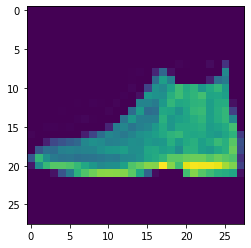

In [110]:
idx = 0
x = X_to_adv[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

Sample instance from the signs data set.


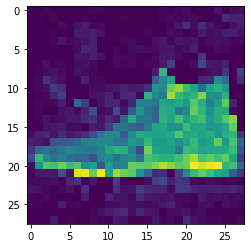

In [111]:
idx = 0
x = X_adv[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the signs data set.')

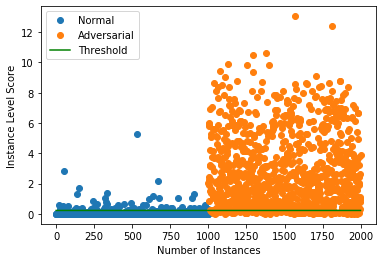

In [93]:
ad_preds = ad.predict(X_val, return_instance_score=True)
y_pred = ad_preds['data']['is_adversarial']
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X_val.shape[0])])
plot_instance_score(ad_preds, target, labels, ad.threshold)